<a href="https://colab.research.google.com/github/kamser0415/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_12%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12강 정형 데이터 분석 : 서울시 공공 자전거 데이터 활용

### 목표

공공 자전거 이용 특성을 파악하고, 날씨와 자전거 이용량의 상관관계를 분석하여 데이터 기반의 정책 수립에 필요한 인사이트를 도출

### 분석 프로세스 개요

1. 데이터 수집 및 전처리
  - CSV 형태의 데이터 수집
  - 기초 통계량 산출
  - 결측치 처리 및 이상치 제거
  - 날짜/시간 데이터 형식 변환
2. 데이터 분석
  - 시계열 패턴 분석
3. 연계 분석
  - 강수량 데이터와의 연계 분석
  - 상관관계 분석
  - 정책 제언으로 연결

In [1]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,766 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and dire

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

### 12-1 따릉이 대역 기록 2023-04 업로드 및 압축 해제

- 따릉이 데이터 다운로드
  - [서울 열린데이터 광장](https://data.seoul.go.kr)
  - 검색어 : 따릉이
  - 서울시 따릉이 대여소별 대여/반납 승객수 정보
  - 2023-04 다운로드 후 업로드

In [5]:
!unzip tpss_bcycl_od_statnhm_202304.zip -d tpss_bcycl_od_statnhm_202304

Archive:  tpss_bcycl_od_statnhm_202304.zip
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230401.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230402.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230403.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230404.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230405.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230406.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230407.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230408.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230409.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230410.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230411.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230412.csv  
  inflati

## 12-2 CSV 형태의 데이터 수집

In [6]:
import glob
import pandas as pd

## CSV 파일 목록 가져오기
## 저 패스에 있는 csv 파일을 읽어오기
all_files = glob.glob("tpss_bcycl_od_statnhm_202304/*.csv")
dataframes = []
for filename in all_files:
    ## CSV 파일 읽어서 데이터프레임화
    ## 윈도우 환경에서 만들어진 파일이라서 인코딩 해야한다.
    df = pd.read_csv(filename, encoding='cp949')
    dataframes.append(df)
## 모든 데이터프레임 결합
## 행의 방향으로 쌓으라는 0으로 입력
df = pd.concat(dataframes, axis=0, ignore_index=True)

## 상위 5행 출력
df.head(5)

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,20230404,출발시간,0,ST-1503,목1동_004_3,ST-1503,목1동_004_3,1,1,100
1,20230404,출발시간,0,ST-1676,발산1동_059_3,ST-1676,발산1동_059_3,1,0,0
2,20230404,출발시간,0,ST-1799,이화동_009_1,ST-1799,이화동_009_1,1,1,0
3,20230404,출발시간,0,ST-204,용강동_030_1,ST-204,용강동_030_1,1,0,0
4,20230404,출발시간,0,ST-2184,이촌1동_045_1,ST-2184,이촌1동_045_1,1,1,0


In [4]:
df

NameError: name 'df' is not defined

## 12-3 기초 통계량 산출

In [7]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계: \n", df.describe())
print("수치형 데이터 요약 통계: \n", df.describe().to_markdown()) ## 사용자 친화적으로

## 범주형 데이터 요약 통계 출력
print("범주형 데이터 요약 통계: \n", df.describe(include=['object']))


수치형 데이터 요약 통계: 
               기준_날짜        기준_시간대         전체_건수       전체_이용_분      전체_이용_거리
count  7.769469e+06  7.769469e+06  7.769469e+06  7.769469e+06  7.769469e+06
mean   2.023042e+07  1.451496e+03  1.075130e+00  2.293263e+01  2.704273e+03
std    8.522043e+00  5.611313e+02  3.092643e-01  3.154944e+01  1.195193e+04
min    2.023040e+07  0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    2.023041e+07  1.020000e+03  1.000000e+00  6.000000e+00  8.540000e+02
50%    2.023042e+07  1.600000e+03  1.000000e+00  1.200000e+01  1.551000e+03
75%    2.023042e+07  1.855000e+03  1.000000e+00  2.700000e+01  2.990000e+03
max    2.023043e+07  2.355000e+03  1.700000e+01  2.001000e+03  1.294437e+07
수치형 데이터 요약 통계: 
 |       |   기준_날짜 |    기준_시간대 |    전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|------------:|---------------:|-------------:|---------------:|-----------------:|
| count | 7.76947e+06 |    7.76947e+06 |  7.76947e+06 |    7.76947e+06 |      7.76947e+06 |
| mean  | 2.02304e+07 | 1451.5

## 12-4 결측치 및 이상치 제거

In [8]:
## 결측치 제거
df = df.dropna() # null 값 제거

## 데이터 전체이용분에서 이상치데이터가 있으므로 제거하는 과정이 필요하다.
## '전체_이용_분' 컬럼 값 필터링 (1분 이하, 180분 이상 제거)
## boolean indexing
df = df[(df['전체_이용_분'] > 1) & df['전체_이용_분'] < 180]

## '전체_이용_거리' 컬럼 값 필터링 (10M 이하, 10000M 이상 제거)
df = df[(df['전체_이용_거리'] > 10) & (df['전체_이용_거리'] < 10000)]

## '집계_기준' 컬럼 필터링 (출발시간만 사용)
df = df[df['집계_기준'] == '출발시간']

## 데이터를 추려서 데이터를 다시 만드는 것입니다.
# 집계 기준을 변화한 것.

In [ ]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계: \n", df.describe())
print("수치형 데이터 요약 통계: \n", df.describe().to_markdown()) ## 사용자 친화적으로

## 범주형 데이터 요약 통계 출력
print("범주형 데이터 요약 통계: \n", df.describe(include=['object']))

## 날짜가 20230411 이라는 큰 숫자로 인식하여 이걸 시간이라는 날짜로 변경하는 과정이 필요하다.

수치형 데이터 요약 통계: 
               기준_날짜        기준_시간대         전체_건수       전체_이용_분      전체_이용_거리
count  3.546433e+06  3.546433e+06  3.546433e+06  3.546433e+06  3.546433e+06
mean   2.023042e+07  1.430269e+03  1.057633e+00  2.018757e+01  2.212241e+03
std    8.491913e+00  5.616489e+02  2.591334e-01  2.407997e+01  1.907058e+03
min    2.023040e+07  0.000000e+00  1.000000e+00  0.000000e+00  1.100000e+01
25%    2.023041e+07  1.000000e+03  1.000000e+00  6.000000e+00  9.170000e+02
50%    2.023042e+07  1.545000e+03  1.000000e+00  1.200000e+01  1.565000e+03
75%    2.023042e+07  1.845000e+03  1.000000e+00  2.400000e+01  2.810000e+03
max    2.023043e+07  2.355000e+03  1.300000e+01  1.111000e+03  9.999000e+03
수치형 데이터 요약 통계: 
 |       |   기준_날짜 |    기준_시간대 |    전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|------------:|---------------:|-------------:|---------------:|-----------------:|
| count | 3.54643e+06 |    3.54643e+06 |  3.54643e+06 |    3.54643e+06 |      3.54643e+06 |
| mean  | 2.02304e+07 | 1430.2

## 12-5 날짜/시간 데이터 형식 변환

In [9]:
## '기준_날짜' 컬럼 datetime 형식으로 변환 (%Y%m%d)
df['기준_날짜'] = pd.to_datetime(df['기준_날짜'], format='%Y%m%d')

## '요일' 컬럼 생성
day_mapping = {
    'Monday': '월요일',
    'Tuesday': '화요일',
    'Wednesday': '수요일',
    'Thursday': '목요일',
    'Friday': '금요일',
    'Saturday': '토요일',
    'Sunday': '일요일'
}

## 함수형 프로그래밍으로 변경
df['요일'] = df['기준_날짜'].dt.day_name().map(day_mapping)

## 전처리 결과 확인

In [10]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계:\n", df.describe().to_markdown())
## 범주형 데이터 요약 통계 출력
print("\n범주형 데이터 요약 통계:\n", df.describe(include=['object']).to_markdown())

수치형 데이터 요약 통계:
 |       | 기준_날짜                     |    기준_시간대 |    전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|:------------------------------|---------------:|-------------:|---------------:|-----------------:|
| count | 3546433                       |    3.54643e+06 |  3.54643e+06 |    3.54643e+06 |      3.54643e+06 |
| mean  | 2023-04-15 16:06:37.823503616 | 1430.27        |  1.05763     |   20.1876      |   2212.24        |
| min   | 2023-04-01 00:00:00           |    0           |  1           |    0           |     11           |
| 25%   | 2023-04-09 00:00:00           | 1000           |  1           |    6           |    917           |
| 50%   | 2023-04-16 00:00:00           | 1545           |  1           |   12           |   1565           |
| 75%   | 2023-04-23 00:00:00           | 1845           |  1           |   24           |   2810           |
| max   | 2023-04-30 00:00:00           | 2355           | 13           | 1111           |   9999           |
| std   | nan     

# 2. 데이터 분석

## 12-6 요일별 이용량 분석

In [11]:
## 요일별 이용량 계산 및 정렬
day_df = df['요일'].value_counts().reindex(day_mapping.values()) ## 인덱스 재설정

## 요일별 이용량 출력
print("요일별 이용량:\n", day_df)

## 시각화해보기

요일별 이용량:
 요일
월요일    600393
화요일    397094
수요일    451350
목요일    484344
금요일    580500
토요일    499250
일요일    533502
Name: count, dtype: int64


## 12-7 요일별 이용량 시각화

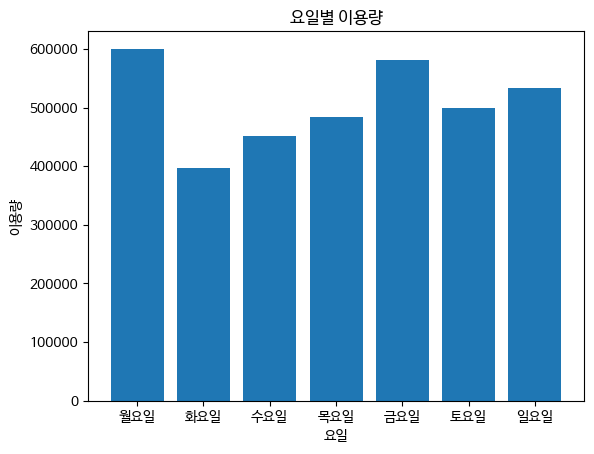

In [12]:
import matplotlib.pyplot as plt

## 요일별 이용량 막대 그래프 생성
plt.bar(day_df.index, day_df.values) # x를 요일별, y는 카운트
plt.title('요일별 이용량')
plt.xlabel('요일')
plt.ylabel('이용량')
plt.show()

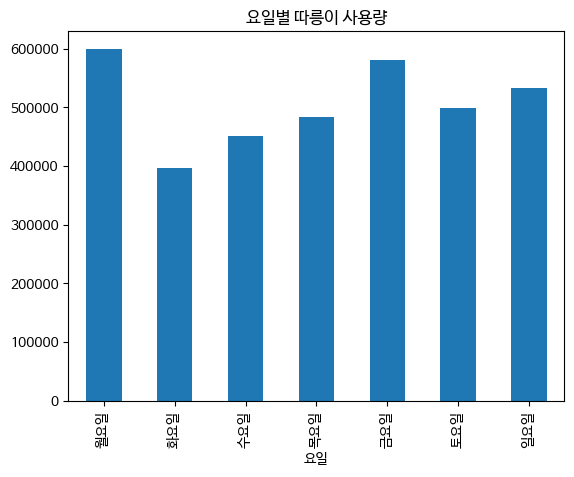

In [13]:
## Dataframe의 plot을 이용한 요일별 이용량 막대 그래프 생성
day_df.plot(kind='bar') # 타이틀이나 축의 값을 설정해줄 수 있다.
plt.title('요일별 따릉이 사용량')
plt.show()

## 12-8 시간별 이용량 분석 및 시각화

시간별 이용량:
 출발_시
0      78014
1      54258
2      34681
3      22716
4      17595
5      29708
6      65424
7     168436
8     257136
9     153378
10    119942
11    139310
12    156823
13    160858
14    169550
15    192698
16    238524
17    305141
18    366392
19    234545
20    186271
21    172312
22    147448
23     75273
Name: count, dtype: int64


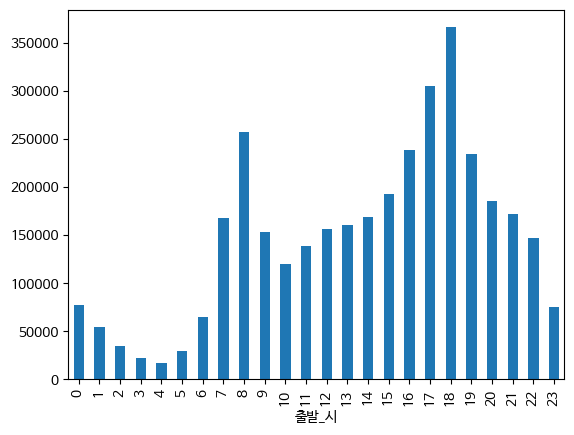

In [16]:
## '출발_시' 컬럼 생성 (기준_시간대 // 100)
df['출발_시'] = df['기준_시간대']//100

## 시간별 이용량 계산 및 정렬 (hour_df로 저장)
hour_df = df['출발_시'].value_counts().sort_index()

## 시간별 이용량 출력
print("시간별 이용량:\n", hour_df)

## 시간별 이용량 막대 그래프 생성
hour_df.plot(kind='bar')
plt.show()

## 12-9 일자별 이용량 분석 및 시각화

일자별 이용량:
 기준_날짜
2023-04-01    132700
2023-04-02    129412
2023-04-03    157200
2023-04-04    124091
2023-04-05     21487
2023-04-06     57516
2023-04-07    126369
2023-04-08    109739
2023-04-09    105047
2023-04-10    145674
2023-04-11     96671
2023-04-12    131033
2023-04-13    135080
2023-04-14    149104
2023-04-15     83075
2023-04-16     94067
2023-04-17    144590
2023-04-18     95521
2023-04-19    159897
2023-04-20    136213
2023-04-21    157121
2023-04-22    129556
2023-04-23    113380
2023-04-24    152929
2023-04-25     80811
2023-04-26    138933
2023-04-27    155535
2023-04-28    147906
2023-04-29     44180
2023-04-30     91596
Name: count, dtype: int64


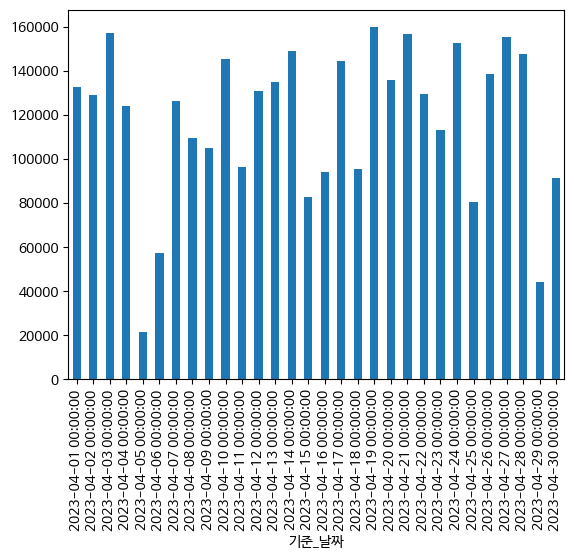

In [15]:
## 일자별 이용량 계산 및 정렬
daily_usage_df = df['기준_날짜'].value_counts().sort_index()
## 일자별 이용량 출력
print("일자별 이용량:\n", daily_usage_df)

## 일자별 이용량 막대 그래프 생성
daily_usage_df.plot(kind='bar')
plt.show()

# 3. 연계 분석

- 기상청 기상자료개방포탈 자료 수집
  - 기후통계분석 > 통계분석 > 조건별통계
  - https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do?pgmNo=179
  - 지역/지점 : 서울
  - 요소 : 강수량
  - 기간 : 일, 2023년 ~ 2023년
  - 조건 : 04월, 01 ~ 31일
- 다운로드 후 파일명 `seoul_rain_2023_04.csv`로 변경하여 colab에 업로드

## 12-10 강수량 데이터 로드

In [17]:
## 강수량 데이터 CSV 파일 로드
file_path = 'seoul_rain_2023_04.csv'
rain_df = pd.read_csv(file_path, encoding='cp949', skiprows=12)
rain_df.head(5)

/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,\t지점번호,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각,Unnamed: 6
0,108,서울,2023-04-01,NaN,NaN,NaN,NaN
1,108,서울,2023-04-02,NaN,NaN,NaN,NaN
2,108,서울,2023-04-03,NaN,NaN,NaN,NaN
3,108,서울,2023-04-04,6.9,3.1,21:38,NaN
4,108,서울,2023-04-05,50.3,9.0,12:10,NaN


## 12-11 강수량 데이터 전처리

In [20]:
## '일시' 컬럼 datetime 형식으로 변환
## 하이픈이 생겼다.
rain_df['일시'] = pd.to_datetime(rain_df['일시'], format='%Y-%m-%d')

## '강수량(mm)' 컬럼 결측치 0으로 채우기
## 따릉이와 데이터 일관성을 맞추기 위해서 0으로 채운다.
rain_df['강수량(mm)'] = rain_df['강수량(mm)'].fillna(0)

## 불필요한 컬럼 제거
rain_df.drop(columns=['\t지점번호', 'Unnamed: 6'], inplace=True)

KeyError: "['\\t지점번호', 'Unnamed: 6'] not found in axis"

/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각
0,서울,2023-04-01,0.0,NaN,NaN
1,서울,2023-04-02,0.0,NaN,NaN
2,서울,2023-04-03,0.0,NaN,NaN
3,서울,2023-04-04,6.9,3.1,21:38
4,서울,2023-04-05,50.3,9.0,12:10
5,서울,2023-04-06,2.7,1.5,19:02
6,서울,2023-04-07,0.0,NaN,NaN
7,서울,2023-04-08,0.0,NaN,NaN
8,서울,2023-04-09,0.0,NaN,NaN
9,서울,2023-04-10,0.0,NaN,NaN


## 12-12 일자별 이용량 데이터와 강수량 데이터 병합

In [25]:
## 일자별 이용량과 강수량 데이터 병합 (daily_usage_gf의 기준_날짜, rain_df의 일시를 기준으로 결합)
merged_df = pd.merge(daily_usage_df, rain_df, how='left',left_on='기준_날짜',right_on='일시')

## 'count' 컬럼명 '이용량'으로 변경
merged_df.rename(columns={'count':'이용량'}, inplace=True)

merged_df.rename(columns={'count': '이용량'}, inplace=True)
## 병합된 데이터프레임 상위 5행 출력
merged_df.head(5)

/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,이용량,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각
0,132700,서울,2023-04-01,0.0,NaN,NaN
1,129412,서울,2023-04-02,0.0,NaN,NaN
2,157200,서울,2023-04-03,0.0,NaN,NaN
3,124091,서울,2023-04-04,6.9,3.1,21:38
4,21487,서울,2023-04-05,50.3,9.0,12:10


## 12-13 이용량 및 강수량 시각화

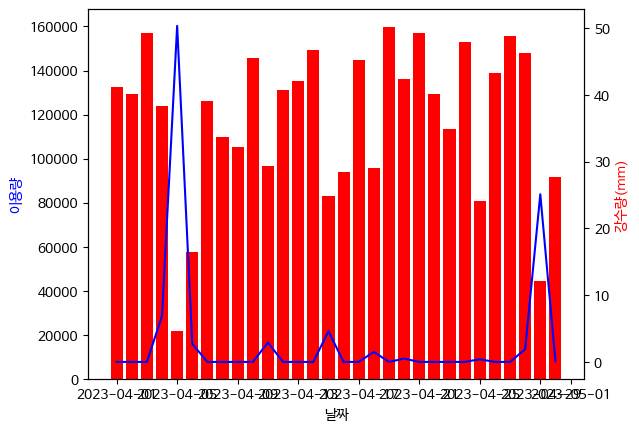

In [28]:
## 두 개의 y축을 가진 서브플롯 생성
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() ## 두 번째 y축 생성

## 첫 번째 y축에 이용량 막대 그래프 그리기
ax1.bar(merged_df['일시'],merged_df['이용량'], color='red')

## 두 번째 y축에 강수량 꺾은선 그래프 그리기
ax2.plot(merged_df['일시'], merged_df['강수량(mm)'], color='blue')


## x축 및 y축 레이블 설정
ax1.set_xlabel('날짜')
ax1.set_ylabel('이용량', color='b')
ax2.set_ylabel('강수량(mm)', color='r')

## 그래프 표시
plt.show()

## 12-14 강수량과 이용량 상관관계 분석

강수량과 이용량의 상관계수: -0.7121037278571696


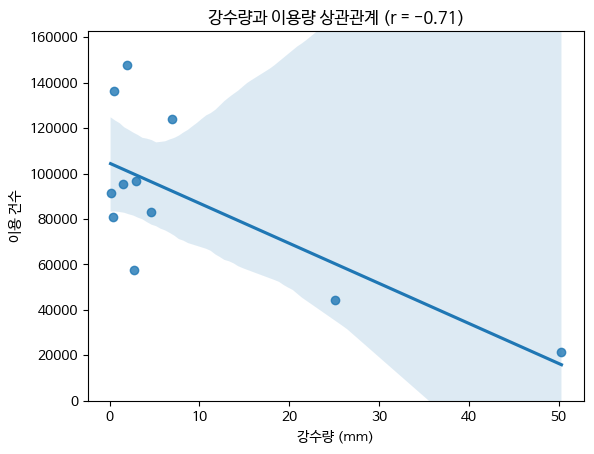

In [29]:
import seaborn as sns ## seaborn 라이브러리 임포트

## 강수량이 있는 날만 필터링
merged_onlyrain_df = merged_df[merged_df['강수량(mm)'] > 0]

## 강수량과 이용량의 상관계수 계산
corr = merged_onlyrain_df['이용량'].corr(merged_onlyrain_df['강수량(mm)'])
## 상관계수 출력
print("강수량과 이용량의 상관계수:", corr)

## 강수량과 이용량의 회귀선 그래프 생성
ax = sns.regplot(x='강수량(mm)', y='이용량',data=merged_onlyrain_df)

## y축 범위 설정
plt.ylim(0, merged_onlyrain_df['이용량'].max()*1.1)

## 그래프 제목 및 축 레이블 설정
plt.title(f'강수량과 이용량 상관관계 (r = {corr:.2f})')
plt.xlabel('강수량 (mm)')
plt.ylabel('이용 건수')
## 그래프 표시
plt.show()

## -0.71 강한 음의 비례 관계라는 의미다.

## 12-15 OLS 회귀 모델 생성 및 분석 및 귀무가설 검증

In [30]:
import statsmodels.formula.api as smf ## statsmodels.formula.api 임포트

## 컬럼명 변경: '강수량(mm)' -> '강수량_mm' (formula API 호환을 위해)
merged_onlyrain_df = merged_onlyrain_df.copy()

## 괄호가 있으면 사용이 안되므로 광호를 제거했다.
merged_onlyrain_df.rename(columns={'강수량(mm)': '강수량_mm'}, inplace=True)

## OLS 모델 정의 및 학습
## 통계학적으로 의미가 있는지 분석한다.
model = smf.ols(formula='이용량 ~ 강수량_mm', data=merged_onlyrain_df)


results = model.fit()

## 모델 요약 결과 출력
print(results.summary())

## 귀무가설 검증 해석
## 강수량_mm 계수에 대한 p-value를 확인하여 귀무가설 (강수량이 이용량에 미치는 영향이 0이다) 검증
## 일반적으로 p-value가 0.05 미만이면 귀무가설을 기각하고 유의미한 영향이 있다고 해석

print("\n--- 귀무가설 검증 (강수량 계수) ---")
p_value = results.pvalues['강수량_mm']
print(f"강수량_mm 계수의 p-value: {p_value:.4f}")
if p_value < 0.05:
    print("p-value가 0.05보다 작으므로 귀무가설을 기각합니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미칩니다.")
else:
    print("p-value가 0.05보다 크므로 귀무가설을 기각할 수 없습니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미치지 않는다고 볼 수 있습니다.")

                            OLS Regression Results                            
Dep. Variable:                    이용량   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     9.259
Date:                Mon, 24 Nov 2025   Prob (F-statistic):             0.0140
Time:                        14:08:17   Log-Likelihood:                -127.29
No. Observations:                  11   AIC:                             258.6
Df Residuals:                       9   BIC:                             259.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.045e+05   9962.011     10.494      0.0